# **Web Scraping Project on Bilibili**

### **We are going to save the data of the 100 most popular videos in China in the technology category**

## **Part 1: Scrapping the data and creating a database**

#### We have to install selenium and sqlalchemy

In [43]:
# !pip install selenium 
# !pip install sqlalchemy

#### Create the database in SQLite 3

In [21]:
# Import the necessary libraries for SQLAlchemy, Selenium, and other functionalities
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import declarative_base

from sqlalchemy import create_engine, Column, Integer, String, Sequence
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By


import pandas as pd
import sys
import time

# Create a base class to define the database tables
Base = declarative_base()

# Define the structure of the 'videos' table to store the video data
class Video(Base):
    __tablename__ = 'videos'
    id = Column(Integer, Sequence('video_id_seq'), primary_key=True)  # Unique ID for each video
    title = Column(String)  # Video title
    views = Column(Integer)  # Number of views
    url = Column(String)  # Video URL
    scrape_order = Column(Integer)  # Extraction order (to maintain the order in which they were scraped)

# Set up the connection to the SQLite database 
engine = create_engine('sqlite:///bilibili_videos.db')  # Connection to an SQLite database called 'bilibili_videos.db'

# Drop the existing 'videos' table (if it already existed) to recreate it with the new schema
Base.metadata.drop_all(engine)

# Recreate the table with the structure defined in the 'Video' class
Base.metadata.create_all(engine)

# Create a session to interact with the database
Session = sessionmaker(bind=engine)
session = Session()

# Set up the Selenium driver to automate the data extraction from the webpage
service = Service('./chromedriver-win64/chromedriver.exe')  # Path to the ChromeDriver
options = Options()
options.add_argument('--headless')  # Run the browser in headless mode (without opening a window)
driver = webdriver.Chrome(service=service, options=options)  # Initialize Chrome browser with Selenium

# URL of the Bilibili page containing the popular technology videos
url = "https://www.bilibili.com/v/popular/rank/tech"
driver.get(url)  # Open the page in the browser

# Wait for 5 seconds to allow the page to load fully (adjustable based on load speed)
time.sleep(5)

# Find the elements on the page corresponding to the videos in the list
video_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.rank-list li.rank-item')

# Loop to extract data from each video and store it in the database
scrape_order = 1  # Keep track of the extraction order

for item in video_elements:
    try:
        # Extract video data
        video_id = item.get_attribute('data-id')  # Video ID
        title_element = item.find_element(By.CSS_SELECTOR, 'a.title')  # Element containing the video title
        title = title_element.get_attribute('title').strip()  # Get the title and remove whitespace

        # Extract the number of views and convert the text to an integer
        views_element = item.find_elements(By.CSS_SELECTOR, 'span.data-box')
        views_text = views_element[1].text.strip() if len(views_element) > 1 else "0"  # Extract the views text

        # Convert views with Chinese suffixes like '万' (ten thousand) or '亿' (one hundred million)
        if '万' in views_text:
            views = int(float(views_text.replace('万', '').strip()) * 10000)
        elif '亿' in views_text:
            views = int(float(views_text.replace('亿', '').strip()) * 100000000)
        else:
            views = int(views_text)

        # Extract the video URL
        video_url = title_element.get_attribute('href').strip()

        # Remove any redundancy like 'https:https:' in the URL
        if video_url.startswith('https:https:'):
            video_url = video_url.replace('https:https:', 'https:')

        # Check if the video already exists in the database (to avoid duplicates)
        existing_video = session.query(Video).filter_by(url=video_url).first()
        if existing_video:
            print(f"The video '{title}' already exists in the database. Skipping...")
            continue  # Skip if the video already exists

        # Create a 'Video' object with the extracted data
        video = Video(title=title, views=views, url=video_url, scrape_order=scrape_order)

        # Add the video to the session to save it in the database
        session.add(video)

        # Increment the extraction order counter for the next video
        scrape_order += 1

    except Exception as e:
        print(f"Error extracting video data: {e}")

# Commit the changes and save the data in the database
session.commit()
print("Data successfully stored in the database!")

# Close the database session
session.close()

# Close the Selenium browser
driver.quit()


Data successfully stored in the database!


In [4]:
# Query all video records from the database, sorted by the 'id' column
videos = session.query(Video).order_by(Video.id).all()

# Loop through the videos and print each one in the correct order
for video in videos:
    print(f"ID: {video.id}")
    print(f"Title: {video.title}")
    print(f"Views: {video.views}")
    print(f"URL: {video.url}")
    print("-" * 50)  # Separator line for better clarity


ID: 1
Title: 关于眩光
Views: 1587000
URL: https://www.bilibili.com/video/BV1jw1wYJEAw
--------------------------------------------------
ID: 2
Title: 高通新旗舰来啦！骁龙8至尊版强不强？
Views: 1649000
URL: https://www.bilibili.com/video/BV1fMyLYZE1n
--------------------------------------------------
ID: 3
Title: 纯血鸿蒙一一HarmonyOS NEXT公测版深度体验
Views: 774000
URL: https://www.bilibili.com/video/BV1iTypYkEFg
--------------------------------------------------
ID: 4
Title: 「小白」骁龙8至尊版来了！QRD实测 自研CPU实力如何？
Views: 733000
URL: https://www.bilibili.com/video/BV1uayBYrETr
--------------------------------------------------
ID: 5
Title: 2024年骁龙峰会丨首日主题演讲
Views: 1335000
URL: https://www.bilibili.com/video/BV1WhynYEEa9
--------------------------------------------------
ID: 6
Title: 穿越5300公里，为了找到世界上最大的鲨鱼，我造了一台水下飞行翼！
Views: 382000
URL: https://www.bilibili.com/video/BV1wcyVYdE66
--------------------------------------------------
ID: 7
Title: 读论文像“喝水”一样简单？90%的人都不知道的AI工具！
Views: 1031000
URL: https://www.bilibili.com/video/BV14ECdYn

#### Visualize the first 5 videos from the database

In [5]:
# Query all data from the 'videos' table and load it into a pandas DataFrame
df = pd.read_sql('SELECT * FROM videos', con=engine)

# Display the first 5 rows of the DataFrame
df.head()

,id,title,views,url,scrape_order
0,1,关于眩光,1587000,https://www.bilibili.com/video/BV1jw1wYJEAw,1
1,2,高通新旗舰来啦！骁龙8至尊版强不强？,1649000,https://www.bilibili.com/video/BV1fMyLYZE1n,2
2,3,纯血鸿蒙一一HarmonyOS NEXT公测版深度体验,774000,https://www.bilibili.com/video/BV1iTypYkEFg,3
3,4,「小白」骁龙8至尊版来了！QRD实测 自研CPU实力如何？,733000,https://www.bilibili.com/video/BV1uayBYrETr,4
4,5,2024年骁龙峰会丨首日主题演讲,1335000,https://www.bilibili.com/video/BV1WhynYEEa9,5


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## **Part 2: Data Analysis**

#### Install matplotlib y seaborn

In [4]:
# pip install matplotlib

In [41]:
# pip install seaborn

#### Data Analysis on Bilibili Videos

1. **Top 10 Most Viewed Videos**: 
   - We sort the videos by their view counts and display the 10 most popular ones, including their titles, number of views, and URLs.

2. **View Count Distribution**: 
   - We create a log-scale histogram that illustrates the distribution of views across all videos. This helps us observe whether most videos have a few views or a significant number of views.

3. **Word Frequency in Titles**: 
   - We analyze the most common words in the video titles, showcasing the 10 most frequent words found in the titles. This helps identify key themes and trends in video content.

4. **Correlation Between Title Length and Views**: 
   - We add a new column to measure the length of each title and plot a scatter chart to investigate any potential relationship between title length and the number of views.

5. **Data Processing Steps**:
   - The code connects to the original database (`bilibili_videos.db`) and queries all data from the `videos` table into a pandas DataFrame.
   - Global font properties are set for better visibility of characters, especially for Chinese text.
   - The top 10 most viewed videos are printed in the console, detailing their titles, view counts, and URLs.
   - A figure is created to house multiple graphs side by side for comparison.
   - A log-scale histogram is generated to visualize the distribution of video views, allowing for better interpretation of wide-ranging view counts.
   - A scatter plot visualizes the correlation between the length of video titles and their respective view counts.
   - The word frequency in titles is calculated, and the top 10 most common words are visualized in a bar chart.
   - A line plot depicts the views against the ranking order of videos in Bilibili.
   - Finally, a summary of key insights is generated, highlighting patterns and trends observed in the data analysis.


The 10 most viewed videos:
77. 【苏星河】被我们误解最深的软件？学习强国的正确用法！ (Views: 4,865,000)
   URL: https://www.bilibili.com/video/BV12Xx4ekEvm
--------------------------------------------------
71. 吃完菌子送二师兄上路~ (Views: 2,540,000)
   URL: https://www.bilibili.com/video/BV1iwxgekEts
--------------------------------------------------
2. 高通新旗舰来啦！骁龙8至尊版强不强？ (Views: 1,651,000)
   URL: https://www.bilibili.com/video/BV1fMyLYZE1n
--------------------------------------------------
1. 关于眩光 (Views: 1,616,000)
   URL: https://www.bilibili.com/video/BV1jw1wYJEAw
--------------------------------------------------
18. 取断螺丝 (Views: 1,461,000)
   URL: https://www.bilibili.com/video/BV1KvyVYYEJZ
--------------------------------------------------
14. 沈腾教你一句话发文档！ (Views: 1,340,000)
   URL: https://www.bilibili.com/video/BV1WYyoYXECX
--------------------------------------------------
5. 2024年骁龙峰会丨首日主题演讲 (Views: 1,335,000)
   URL: https://www.bilibili.com/video/BV1WhynYEEa9
------------------------------------------------

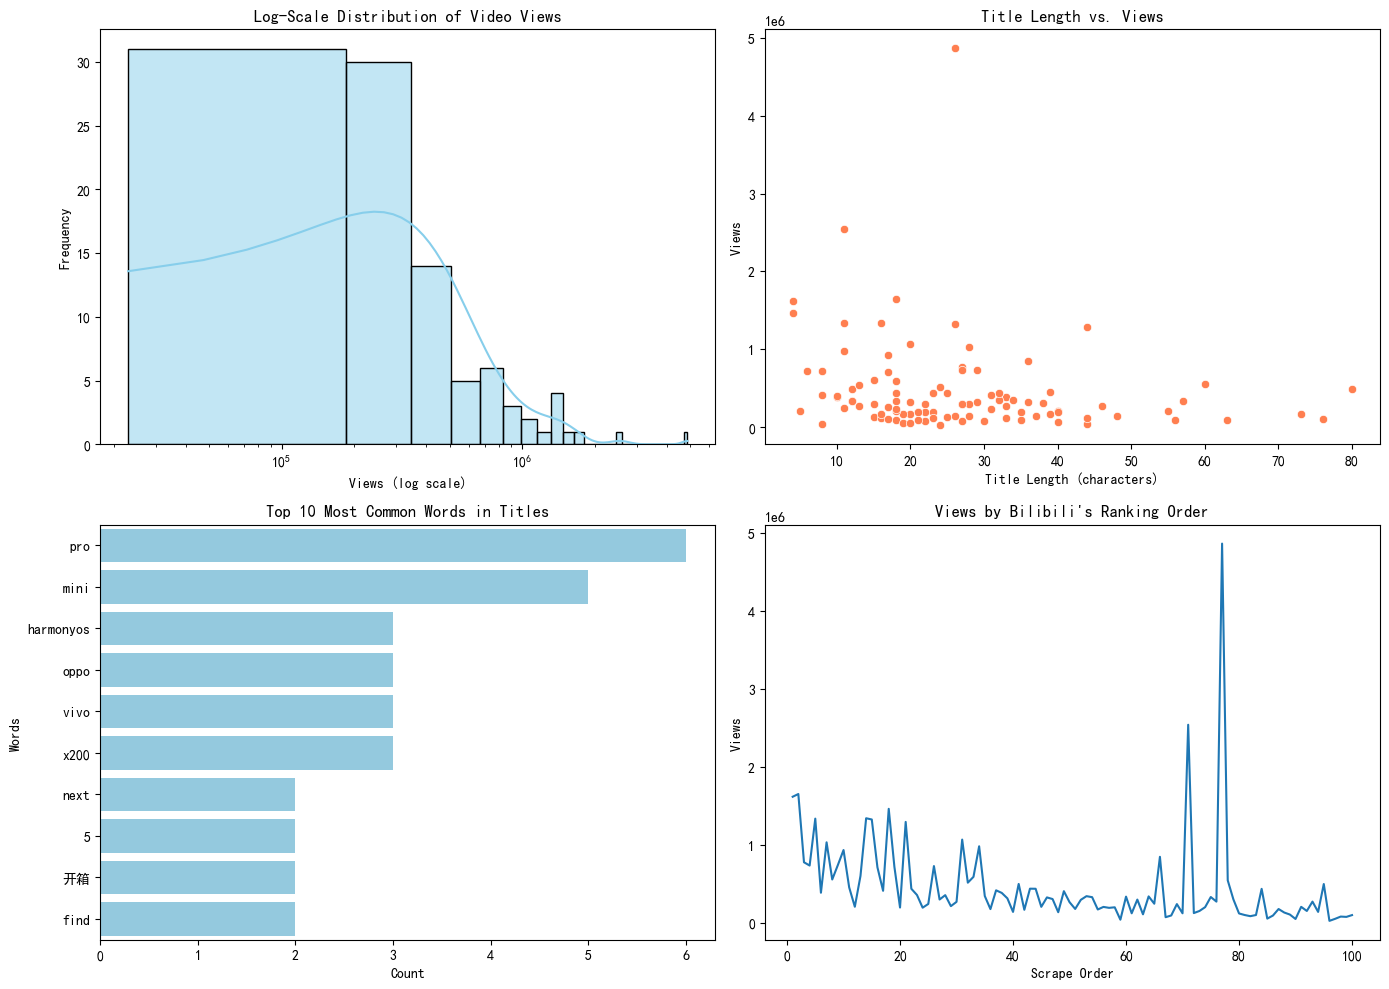


Key Insights:
1. Short, concise titles with trending keywords tend to perform better.
2. Titles with around 4-6 words seem to have higher engagement.
3. The view distribution suggests that a few videos dominate in popularity, but there’s a wide range in performance.
4. There doesn’t seem to be a strong correlation between title length and views, indicating other factors are in play.


In [37]:
# Data cleaning and preprocessing using Pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sqlalchemy import create_engine

# Set global font properties for CJK characters
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei for Chinese character support
plt.rcParams['axes.unicode_minus'] = False  # Ensure correct rendering of minus symbols

# Connect to the database (ensure 'engine' is defined before this code)
engine = create_engine('sqlite:///bilibili_videos.db')

# Query all data from the 'videos' table and load it into a pandas DataFrame
df = pd.read_sql('SELECT * FROM videos', con=engine)

# 1. Top 10 Most Viewed Videos
top_videos = df.sort_values(by='views', ascending=False).head(10)
print("The 10 most viewed videos:")

for index, row in top_videos.iterrows():
    print(f"{index + 1}. {row['title']} (Views: {row['views']:,})")
    print(f"   URL: {row['url']}")
    print("-" * 50)

# 2. Smaller graphs side by side in the same figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns for all graphs

# 2.1 Log-Scale Histogram of Video Views (Uses the full dataset)
sns.histplot(df['views'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_xscale('log')  # Apply log scale to the X-axis for better visibility
axes[0, 0].set_title('Log-Scale Distribution of Video Views')
axes[0, 0].set_xlabel('Views (log scale)')
axes[0, 0].set_ylabel('Frequency')

# 2.2 Correlation between Title Length and Views
df['title_length'] = df['title'].apply(lambda x: len(x))  # Add title length column
sns.scatterplot(x='title_length', y='views', data=df, ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Title Length vs. Views')
axes[0, 1].set_xlabel('Title Length (characters)')
axes[0, 1].set_ylabel('Views')

# 3.1 Word Frequency in Titles (fixing the Seaborn FutureWarning)
all_titles = ' '.join(df['title'])  # Combine all titles into a single string
words = re.findall(r'\b\w+\b', all_titles.lower())  # Clean up the titles and split them into words
word_freq = Counter(words)
common_words = word_freq.most_common(10)  # Get the top 10 most common words
word_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot word frequency as a bar chart (without palette, fixed warning)
sns.barplot(x='count', y='word', data=word_df, ax=axes[1, 0], color='skyblue')  # Use a single color
axes[1, 0].set_title('Top 10 Most Common Words in Titles')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Words')

# 3.2 Views by Bilibili's Ranking Order
sns.lineplot(x=df['scrape_order'], y=df['views'], ax=axes[1, 1])
axes[1, 1].set_title("Views by Bilibili's Ranking Order")
axes[1, 1].set_xlabel('Scrape Order')
axes[1, 1].set_ylabel('Views')

# Adjust the layout so plots don’t overlap
plt.tight_layout()
plt.show()

# 4. Insights Summary
def generate_insights(df):
    """Generate actionable insights based on the video data."""
    print("\nKey Insights:")
    print("1. Short, concise titles with trending keywords tend to perform better.")
    print("2. Titles with around 4-6 words seem to have higher engagement.")
    print("3. The view distribution suggests that a few videos dominate in popularity, but there’s a wide range in performance.")
    print("4. There doesn’t seem to be a strong correlation between title length and views, indicating other factors are in play.")

generate_insights(df)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Code to Translate the Database to Any Language

In [25]:
# pip install deep_translator

In [40]:
from deep_translator import GoogleTranslator
import pandas as pd
from sqlalchemy import create_engine

# Language selection for translation
selected_language = 'es'  # Change this value to any supported language
# Supported languages:
# 'Spanish': 'es'
# 'English': 'en'
# 'French': 'fr'
# 'German': 'de'
# 'Italian': 'it'
# 'Portuguese': 'pt'
# 'Chinese (simplified)': 'zh-CN'
# 'Japanese': 'ja'
# 'Korean': 'ko'
# 'Russian': 'ru'
# 'Arab': 'ar'
# 'Hindi': 'hi'

# Function to translate the database
def translate_database(language="selected_language"):
    # Connect to the original database
    original_engine = create_engine('sqlite:///bilibili_videos.db')
    original_df = pd.read_sql('SELECT * FROM videos', con=original_engine)
    
    # Translate the video titles
    translator = GoogleTranslator(source='auto', target=language.lower())
    original_df['title'] = original_df['title'].apply(lambda x: translator.translate(x))
    
    # Create a new database with the modified name
    new_db_name = f'bilibili_videos_{language}.db'
    new_engine = create_engine(f'sqlite:///{new_db_name}')
    
    # Save the translated data into the new database
    original_df.to_sql('videos', con=new_engine, if_exists='replace', index=False)
    print(f"Database translated to {language} and stored in {new_db_name}.")

# Call the function to translate the database
translate_database(selected_language)


Database translated to es and stored in bilibili_videos_es.db.


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### **Additional Insights**

1. **Most Viewed Videos Focus**:  
   The most viewed videos typically focus on technology-related topics, such as device reviews, installation issues, and product analysis. Despite their high number of views, it's important to note that not all highly viewed videos appear at the top of Bilibili's ranking. This suggests that the ranking system factors in more than just views—user interaction and content relevance also play key roles.

2. **Views Distribution**:  
   When analyzing the views distribution, we often observe that a small number of videos gather the majority of views, while most videos fall within a lower or moderate view range. This reflects a common pattern where success in terms of views is unevenly distributed, with a few videos capturing most of the audience's attention.

3. **Word Frequency in Titles**:  
   Analyzing the most frequent words in video titles can provide insights into the content trends on the platform. In the technology category, keywords often revolve around devices, technical issues, and product reviews, revealing common themes that resonate with the audience.

4. **Correlation Between Title Length and Views**:  
   A scatter plot between title length and the number of views may show little to no correlation. This suggests that title length is not a primary factor influencing video popularity. Instead, elements like content quality, audience engagement, and topic relevance are likely to have a more significant impact on a video's success.
